In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import skew
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

/Users/mi-tomoya/.pyenv/versions/3.6.5/envs/ur5/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
#データの読み込み
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

#外れ値の処理
df_train = df_train[~((df_train['GrLivArea'] > 4000) & (df_train['SalePrice'] < 300000))]
df_train.drop(df_train[(df_train['YearBuilt']<1900) & (df_train['SalePrice']>500000)].index,inplace=True)

#Id及びSaleprice以外の全データを結合(左端=Id, 右端はSalePrice)
df_all = pd.concat((df_train.loc[:,'MSSubClass':'SaleCondition'], df_test.loc[:,'MSSubClass':'SaleCondition']))

#Feature Engineering 
df_all['TotalHousePorchSF'] = df_all['EnclosedPorch']+df_all['OpenPorchSF']+df_all['WoodDeckSF']+df_all['3SsnPorch']+df_all['ScreenPorch']
df_train['TotalHousePorchSF'] = df_train['EnclosedPorch']+df_train['OpenPorchSF']+df_train['WoodDeckSF']+df_train['3SsnPorch']+df_train['ScreenPorch']

df_train['Pooldammy'] = (df_train['PoolArea'] > 0) * 1
df_all['Pooldammy'] = (df_all['PoolArea'] > 0) * 1

df_train['Fire'] = (df_train['Fireplaces'] > 0) * 1
df_all['Fire'] = (df_all['Fireplaces'] > 0) * 1

# df_train['year'] = df_train['YearRemodAdd'] - df_train['YearBuilt']
# df_all['year'] = df_all['YearRemodAdd'] - df_all['YearBuilt']

df_train['Fencedammy'] = df_train['Fence']
(df_train['Fencedammy'])[df_train['Fence'].isnull()]=0
(df_train['Fencedammy'])[~df_train['Fence'].isnull()]=1
(df_train['Fencedammy'])[df_train['Fence'] != 'NA']= 0
df_all['Fencedammy'] = df_all['Fence']
(df_all['Fencedammy'])[df_all['Fence'].isnull()]=0
(df_all['Fencedammy'])[~df_all['Fence'].isnull()]=1
(df_all['Fencedammy'])[df_all['Fence'] != 'NA']= 0

df_train['Gdammy'] = df_train['GarageType']
(df_train['Gdammy'])[df_train['GarageType'].isnull()]=0
(df_train['Gdammy'])[~df_train['GarageType'].isnull()]=1
(df_train['Gdammy'])[df_train['GarageType'] != 'NA']= 0
df_all['Gdammy'] = df_all['GarageType']
(df_all['Gdammy'])[df_all['GarageType'].isnull()]=0
(df_all['Gdammy'])[~df_all['GarageType'].isnull()]=1
(df_all['Gdammy'])[df_all['GarageType'] != 'NA']= 0

# df_train['Firedammy'] = df_train['GarageType']
# (df_train['Firedammy'])[df_train['GarageType'].isnull()]=0
# (df_train['Firedammy'])[~df_train['GarageType'].isnull()]=1
# (df_train['Firedammy'])[df_train['GarageType'] != 'NA']= 0
# df_all['Firedammy'] = df_all['GarageType']
# (df_all['Firedammy'])[df_all['GarageType'].isnull()]=0
# (df_all['Firedammy'])[~df_all['GarageType'].isnull()]=1
# (df_all['Firedammy'])[df_all['GarageType'] != 'NA']= 0



# print(df_train['Fencedammy'])
# list(set(df_train['Fencedammy'] ))
len(df_all.columns)

df_train.head()

/Users/mi-tomoya/.pyenv/versions/3.6.5/envs/ur5/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mi-tomoya/.pyenv/versions/3.6.5/envs/ur5/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mi-tomoya/.pyenv/versions/3.6.5/envs/ur5/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mi-tomoya/.pyenv/versions/3.6.5/envs/ur5/lib/

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalHousePorchSF,Pooldammy,Fire,Gdammy
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,2,2008,WD,Normal,208500,61,0,0,0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,5,2007,WD,Normal,181500,298,0,1,0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,9,2008,WD,Normal,223500,42,0,1,0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,2,2006,WD,Abnorml,140000,307,0,1,0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,12,2008,WD,Normal,250000,276,0,1,0


In [3]:
d = {}
num = 1
pvt2=pd.crosstab(index=df_train['MSZoning'],columns=df_train['Neighborhood'],values=df_train['SalePrice'],aggfunc='mean')
a = np.mean(pvt2, axis=0).sort_values()
for i in a.keys():
    if(i == "Blueste"):
        num+=1
        d[i] = num
    elif(i == "ClearCr"):
        num+=1
        d[i] = num
    else:
        d[i] = num


df_train['Neighborhood_val'] = 1
for i,j in zip(df_train['Neighborhood'], range(len(df_train['Neighborhood']))):
    df_train['Neighborhood_val'][j] = d[i]


/Users/mi-tomoya/.pyenv/versions/3.6.5/envs/ur5/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
d = {}
num = 1
# df_all['SalePrice'] = df_train['SalePrice']
pvt2=pd.crosstab(index=df_train['MSZoning'],columns=df_train['Neighborhood'],values=df_train['SalePrice'],aggfunc='mean')
a = np.mean(pvt2, axis=0).sort_values()
for i in a.keys():
    if(i == "Blueste"):
        num+=1
        d[i] = num
    elif(i == "ClearCr"):
        num+=1
        d[i] = num
    else:
        d[i] = num


df_all['Neighborhood_val'] = 1
for i,j in zip(df_all['Neighborhood'], range(len(df_all['Neighborhood']))):
    df_all['Neighborhood_val'][j] = d[i]


/Users/mi-tomoya/.pyenv/versions/3.6.5/envs/ur5/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
# df_all.drop("SalePrice", axis=1)

pd.set_option("display.max_rows", 100)

# df_train.drop(df_train[(df_train.corr()['SalePrice'] < 0.01)])

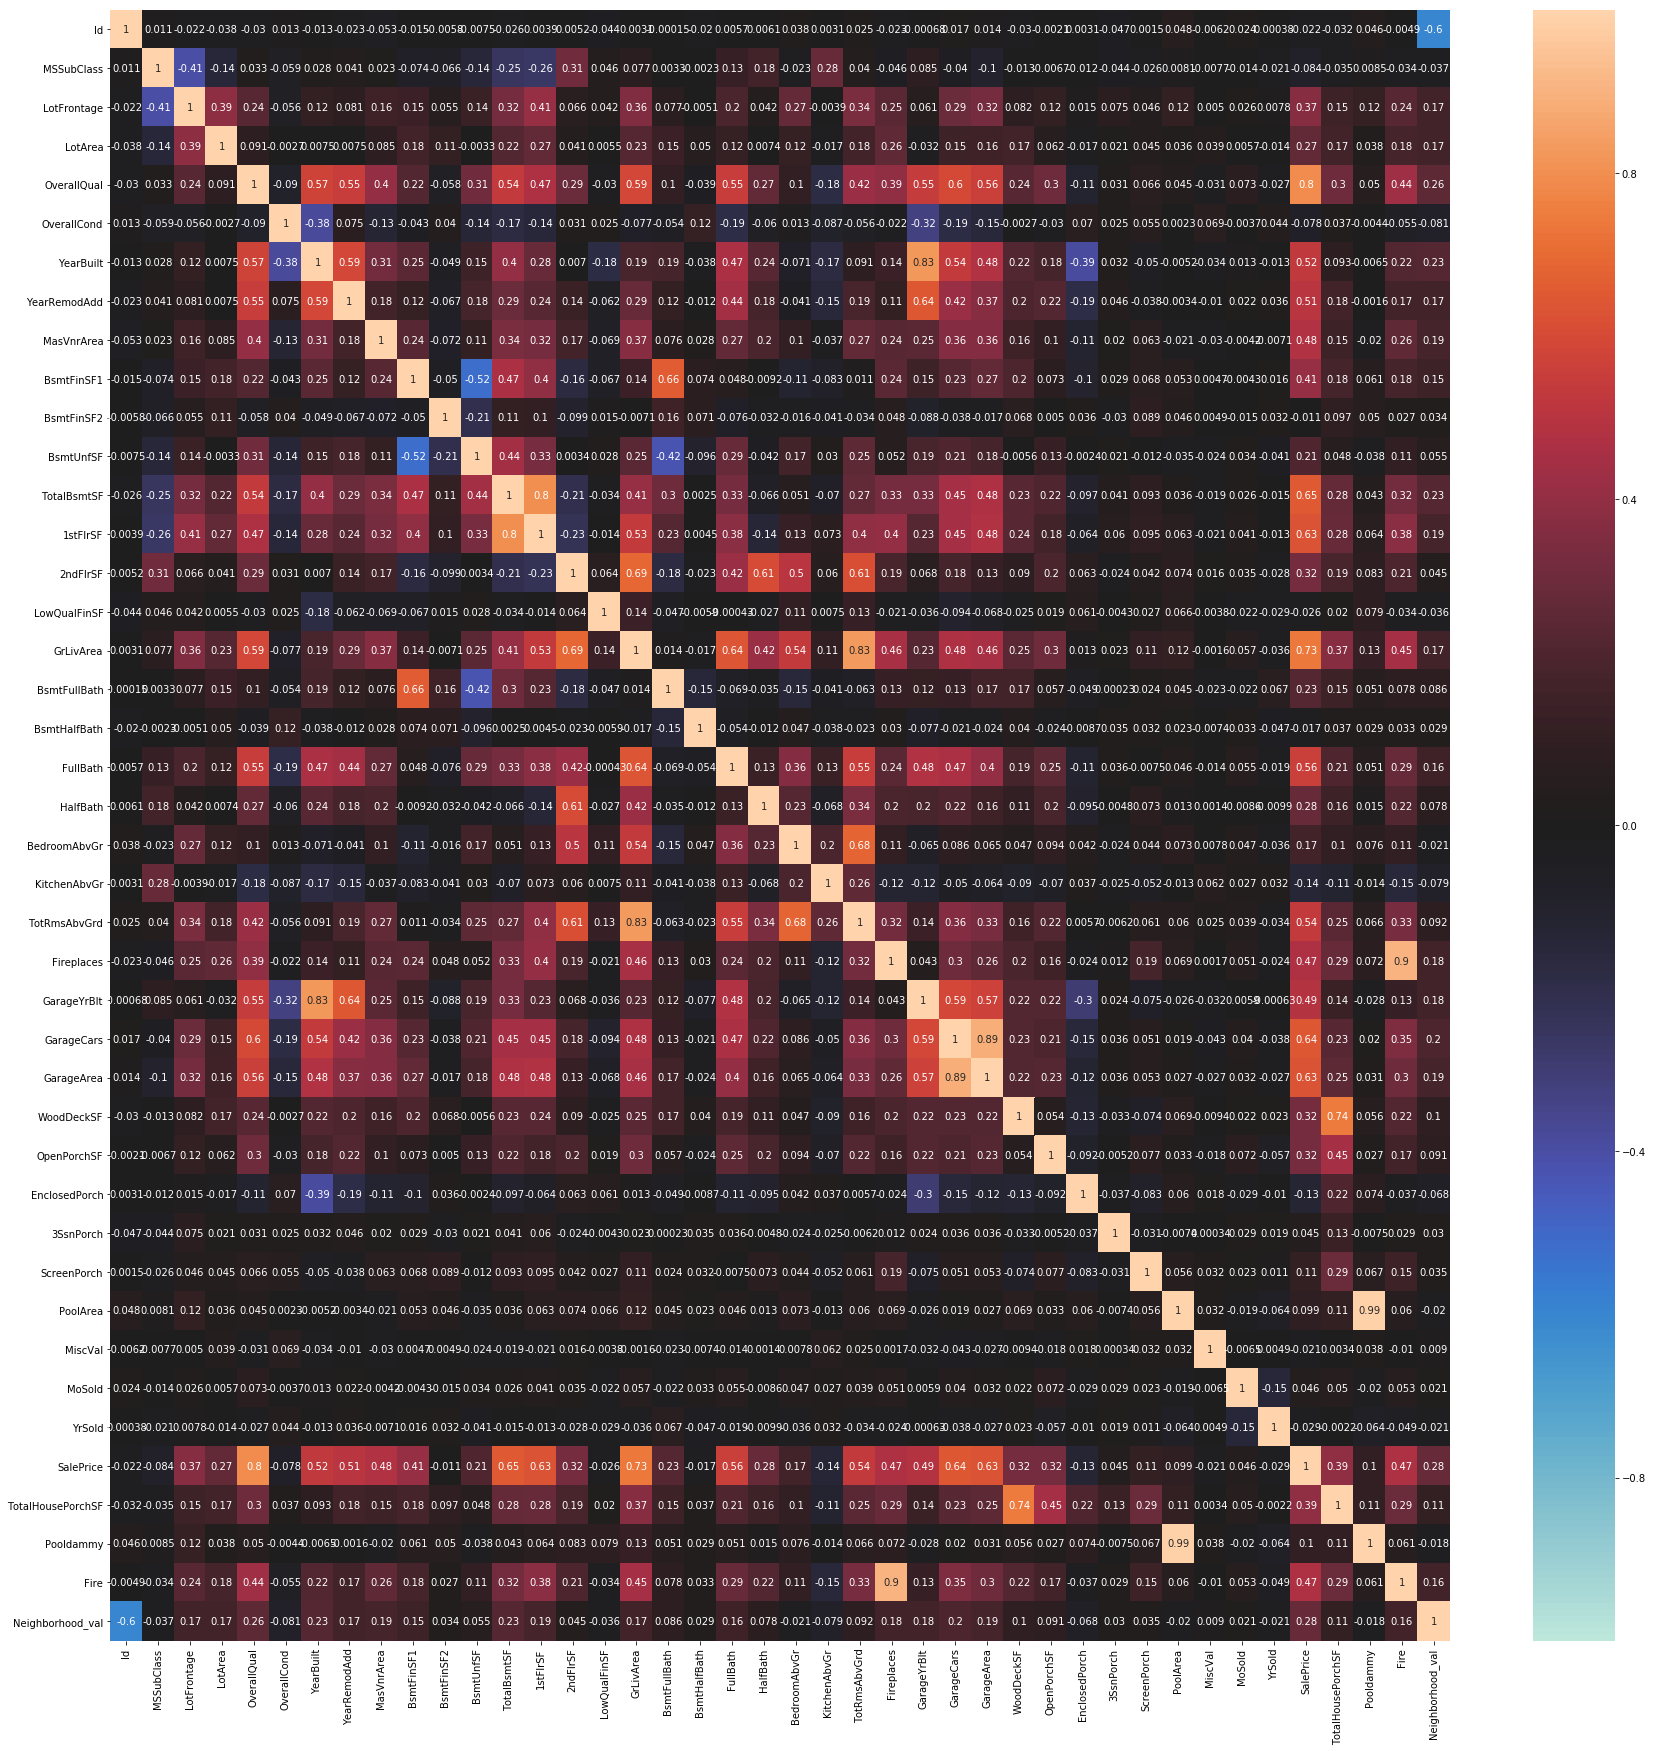

In [6]:
#相関係数行列の可視化
fig, ax = plt.subplots(1, 1, figsize=(30, 30))
sns.heatmap(df_train.corr(), vmax=1, vmin=-1, center=0, annot=True, ax=ax)

In [7]:
df_all.drop(['1stFlrSF','GarageArea','TotRmsAbvGrd', 'GarageYrBlt', 'PoolArea', 'GarageType', 'Fireplaces'], axis=1, inplace=True)
# df_train.drop(['1stFlrSF','GarageArea','TotRmsAbvGrd', 'GarageYrBlt', 'PoolArea', 'GarageType', 'Fireplaces', 'BsmtFinSF2', 'BsmtHalfBath', 'MiscVal', 'LowQualFinSF', 'YrSold'], axis=1, inplace=True)

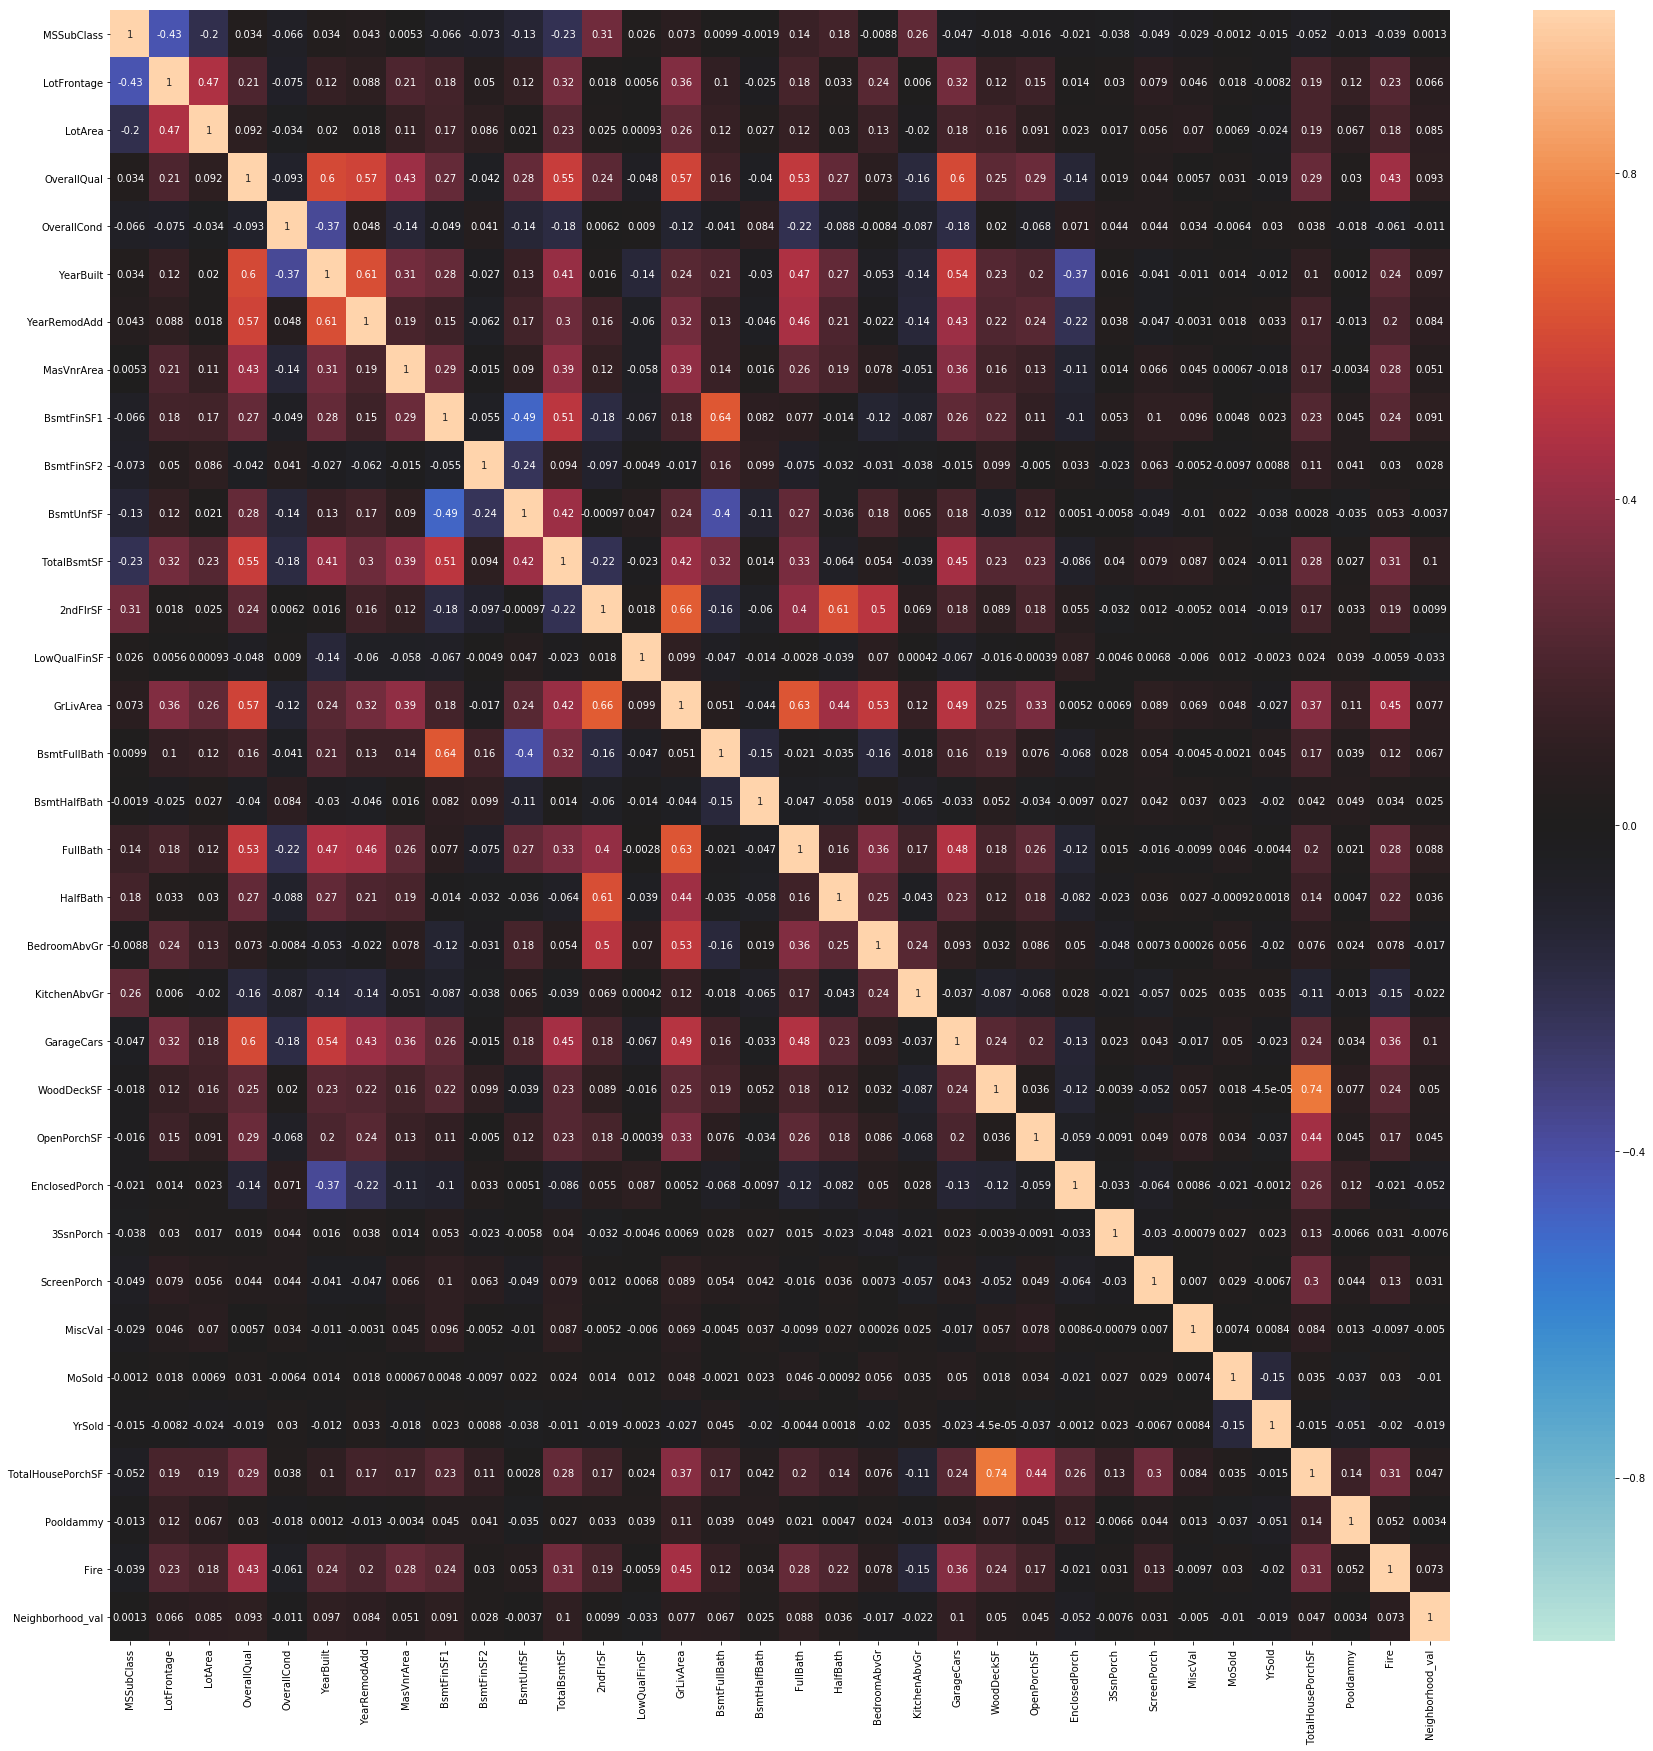

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(30, 30))
sns.heatmap(df_all.corr(), vmax=1, vmin=-1, center=0, annot=True, ax=ax)

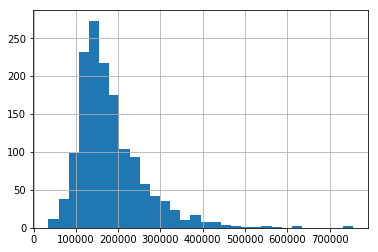

In [9]:
df_train["SalePrice"].hist(bins=30)

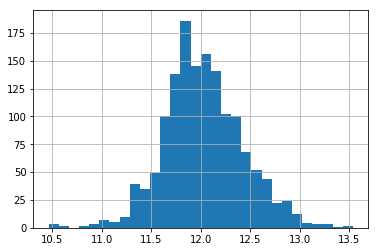

In [10]:
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])
#対数変換後の分布を確認
df_train["SalePrice"].hist(bins=30)

In [11]:
#カテゴリカルでない特徴量
non_categoricals = df_all.dtypes[df_all.dtypes != "object"].index
skewed_feats = df_train[non_categoricals].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.6].index
#歪度0.6より大きい特徴量を対数変換
df_all[skewed_feats] = np.log1p(df_all[skewed_feats])

In [12]:
#One Hot Encoding
df_all = pd.get_dummies(df_all)
#欠損値を平均値で補完
df_all = df_all.fillna(df_all.mean())

In [13]:
# #One Hot Encoding
# df_train = pd.get_dummies(df_train)
# #欠損値を平均値で補完
# df_train = df_train.fillna(df_train.mean())
# print(len(df_train.columns))
# print(len(df_all.columns))

# idx = df_train.corr().sort_values('SalePrice')['SalePrice'][df_train.corr().sort_values('SalePrice')['SalePrice']>0.001].index
# idx.tolist()
# df_train = df_train[df_train.columns & idx.tolist()]

# df_all = df_all[df_all.columns & idx.tolist()]
# print(len(df_train.columns))
# print(len(df_all.columns))
# len(idx)

In [14]:
#学習データ、テストデータに分割
X = df_all[:df_train.shape[0]]

X_for_test = df_all[df_train.shape[0]:]
y = df_train.SalePrice
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1111)
X.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'SaleType_New', 'SaleType_Oth', 'SaleType_WD', 'SaleCondition_Abnorml',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Normal', 'SaleCondition_Partial', 'Gdammy_0'],
      dtype='object', length=280)

In [15]:
import xgboost as xgb
xgb_reg = xgb.XGBRegressor(max_depth=5, n_estimators=500, subsample=0.8)
xgb_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [16]:
#RMSE
y_pred3 = xgb_reg.predict(X_test)
print("xgboostでのRMSE:",np.sqrt(mean_squared_error(y_test, y_pred3)))

xgboostでのRMSE: 0.12239860356087662


In [17]:
from xgboost import plot_importance

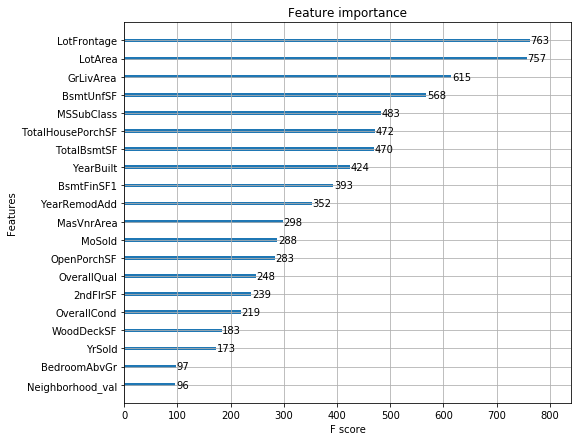

In [18]:
fig, ax = plt.subplots(1,1,figsize=(8,7))
plot_importance(xgb_reg, ax=ax, max_num_features=20)
plt.show()

In [19]:
reg = Lasso(alpha=0.0004)
reg.fit(X_train, y_train)

Lasso(alpha=0.0004, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [20]:
y_pred = reg.predict(X_test)
print("ラッソ回帰でのRMSE:",np.sqrt(mean_squared_error(y_pred, y_test)))

ラッソ回帰でのRMSE: 0.11315092624286181


In [21]:
lgb_train = lgb.Dataset(X_train,y_train)

In [22]:
params = {'task': 'train','boosting_type': 'gbdt','objective': 'regression','metric': {'l2'},'num_leaves': 256,
'learning_rate': 0.01,'num_iterations':2000,'feature_fraction': 0.4,'bagging_fraction': 0.7,'bagging_freq': 5}
gbm = lgb.train(params, lgb_train, num_boost_round=1500)
y_test_pred_lgb = gbm.predict(np.array(X_test), num_iteration=gbm.best_iteration)
#RMSE
print("LightGBMでのRMSE:",np.sqrt(mean_squared_error(y_test, y_test_pred_lgb)))

/Users/mi-tomoya/.pyenv/versions/3.6.5/envs/ur5/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LightGBMでのRMSE: 0.11673774634859549


In [33]:
print("LightGBM+Lassoのスタッキング時のRMSE:",np.sqrt(mean_squared_error(y_test, (y_pred*0.55+y_test_pred_lgb*0.45))))

LightGBM+Lassoのスタッキング時のRMSE: 0.10914954664232615


In [34]:
#全データで学習
reg.fit(X, y)
lgb_train_full = lgb.Dataset(X,y)
gbm = lgb.train(params, lgb_train_full, num_boost_round=1500)

/Users/mi-tomoya/.pyenv/versions/3.6.5/envs/ur5/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [36]:
#ラッソ・LightGBMの予測及びスタッキング
pred = np.expm1(reg.predict(X_for_test))
pred2 = np.expm1(gbm.predict(X_for_test))
pred3 = (pred*0.55+pred2*0.45)

In [37]:
solution = pd.DataFrame({"id":df_test.Id, "SalePrice":pred3})
solution.to_csv("sample3.csv", index = False)